In [3]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
import os
import sys

sns.set_style("white")
sns.set_palette("colorblind")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate
from Speedup import get_percent_speedup
from Plotter import format_plot_2ys

OURSYSTEM = "Selective-Backprop (Us)"
BASELINE = "Baseline"
RANDOM = "Random"
BASELINE_COLOR ="#009e73"


In [4]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [5]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    def __init__(self, filename, experiment_name):
        print(filename)

        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.pool_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "{}, {}, {}, top_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "lowk":
            label = "{}, {}, {}, lowest_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "randomk":
            label = "{}, {}, {}, random_{}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "kath":
            label = "{}, {}, {}, {}/{}".format(self.experiment_name,
                                                      self.strategy,
                                                      self.network,
                                                      int(self.top_k),
                                                      self.pool_size)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            label = "{}, {}, {}, Min: {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network,
                                                   self.top_k) 
        elif self.strategy == "baseline":
            label = "{}, {}, {}".format(self.experiment_name,
                                                   self.strategy,
                                                   self.network) 
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        #if self.seed:
        #    label += ", seed-{}".format(self.seed)
        #else:
        #    label += ", trial-{}".format(self.trial)
        return label
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=10, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * 1.1})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [17]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None,
         ylog=False,
         annotate_accuracy=False):
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        if annotate_accuracy:
            label += ", Acc:{}".format(max(ys))

        if config.top_k == config.pool_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0)

        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax)

        
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = Evaluate.find_first_x_at_y(xs, ys, ymarker)
        if xmarker:
            print("xmarker: ", xmarker)
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                             xlabel,
                                            ylabel,
                                            config.lr)
        if ylog:
            plt.yscale("log")
        format_plot(xlabel, ylabel)
                
        plt.axhline(y=30, color='r', linestyle='-')
        plt.axhline(y=20, color='b', linestyle=':')
        plt.axhline(y=40, color='g', linestyle='-.')
        write_file(plot_prefix, show=True)




In [7]:
def make_instantaneous(l):
    lcopy = l[:]
    lcopy.insert(0, 0)        
    pairs = zip(lcopy[::1], lcopy[1::1])
    ilist = [j - i for i, j in pairs]
    return ilist

def smooth(l, constant):
    for i in range(constant):
        l = [(l+r) / 2. for l, r in zip(l[:-1], l[1:])]
    return l
            
def plot_experiments(experiment_names,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     sampling_mins=None,
                     smoothing=0,
                     xmax=None,
                     ymin=None,
                     ymax=None,
                     ymarker=None):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    test_errors_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name in experiment_names:
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store" or filename == "pickles" or filename == "sha":
                continue
                
            print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_name)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue

            train_num_backprops = [l.num_backprop / 1000000. for l in train_lines]
            test_num_backprops = [l.num_backprop / 1000000. for l in test_lines]
            test_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in test_lines]
            train_num_inferences = [(l.num_backprop + l.num_skip) / 1000000. for l in train_lines]

            instantaneous_train_num_backprops = make_instantaneous(train_num_backprops)
            instantaneous_train_num_inferences = make_instantaneous(train_num_inferences)

            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            test_errors = [100-l.acc for l in test_lines]
            
            ratio_backpropped_ys = smooth([x / float(y) \
                                           for x, y in zip(instantaneous_train_num_backprops,
                                                           instantaneous_train_num_inferences)
                                           if y > 0], 10)
            ratio_backpropped_xs = smooth([l.num_backprop / 1000000. \
                                           for l in train_lines \
                                           if (l.num_backprop + l.num_skip) > 0], 10)
            
            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            test_errors_by_config[config] = test_errors
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys


    plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Num Images Backpropped (millions)", "Ratio Backpropped", plot_dir, smoothing, lw=0.8, ymin=0, xmax=xmax)
    #plot(train_num_backprops_by_config, train_losses_by_config, "Num Images Backpropped (millions)", "Training Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_accuracies_by_config, "Num Images Backpropped (millions)", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, annotate_accuracy=True)
    plot(test_num_backprops_by_config, test_errors_by_config, "Num Images Backpropped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax,  ymarker=ymarker, ylog=True)
    plot(test_num_inferences_by_config, test_errors_by_config, "Num Images Forward Propped (millions)", "Test Error", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, ylog=True)
    plot(test_num_backprops_by_config, test_losses_by_config, "Num Images Backpropped (millions)", "Test Loss", plot_dir, smoothing, lw=1, xmax=xmax)

In [8]:
def plot_percent_speedup(plot_dir, title, nb0s, nb1s, nf1s, labels, max_alpha):
    plot_prefix = "{}/{}".format(plot_dir, title)
    
    for nb0, nb1, nf1, label in zip(nb0s, nb1s, nf1s, labels):
        ys = []
        alphas = range(1, max_alpha + 1)
        for alpha in alphas:
            y = get_percent_speedup(nb0, nb1, nf1, alpha)
            ys.append(y)
        plt.plot(alphas, ys, label=label)
    plt.ylim(-100, 100)

    format_plot("Ratio of Backwards to Forwards Pass Latency", "Percent Speedup")
    write_file(plot_prefix)



sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338

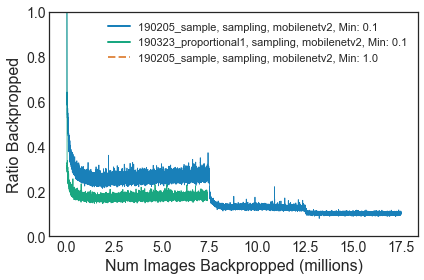

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Accuracy_lr0.0.pdf


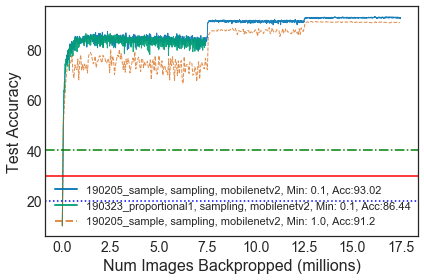

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Error_lr0.0.pdf


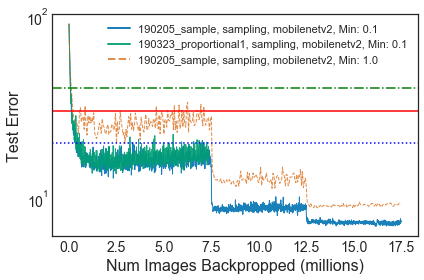

../plots/190320_proportional//190205_sample_Num Images Forward Propped (millions)_Test Error_lr0.0.pdf


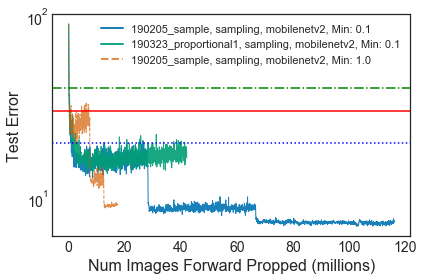

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Loss_lr0.0.pdf


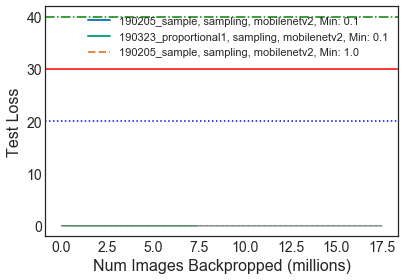

sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_densenet_1_64_0.0_0.0005_trial3_seed1339_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_0.1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338_v2
sampling_cifar10_mobilenet_1_128_0.0_0.0005_trial2_seed1338

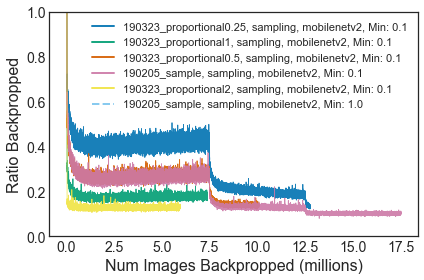

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Accuracy_lr0.0.pdf


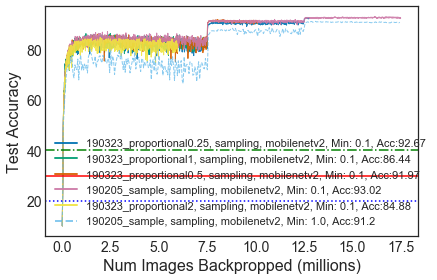

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Error_lr0.0.pdf


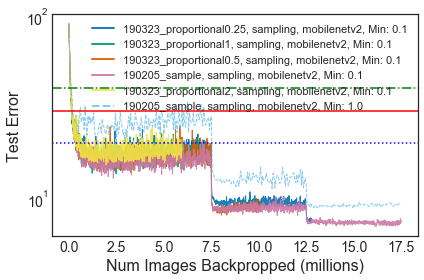

../plots/190320_proportional//190205_sample_Num Images Forward Propped (millions)_Test Error_lr0.0.pdf


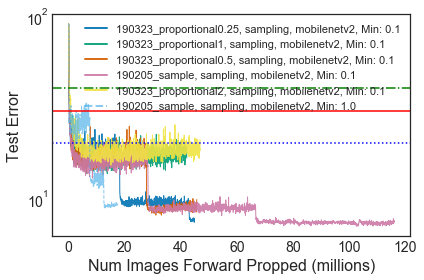

../plots/190320_proportional//190205_sample_Num Images Backpropped (millions)_Test Loss_lr0.0.pdf


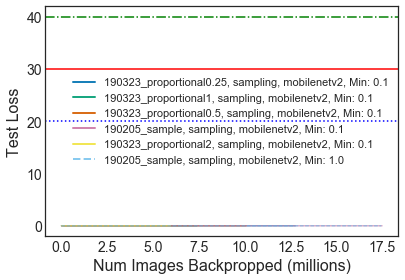

<Figure size 432x288 with 0 Axes>

In [21]:
# proportional + transformation functions

plot_home_dir = "../plots"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190320_proportional/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190205_sample", "190323_proportional1"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"],
                     trials=[1])
    
experiment_names = ["190205_sample", "190323_proportional1", "190323_proportional2", "190323_proportional0.5", "190323_proportional0.25"]

if True:
    plot_experiments(experiment_names,
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2"],
                     trials=[1])
    
if False:
    target_errors = [20, 25, 30, 40]
    for experiment_name in experiment_names:
        print("----------------")
        print(experiment_name)
        print("----------------")
        filedir = os.path.join(experiment_dir, experiment_name)
        filepath = os.path.join(filedir, "sampling_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2")
        Evaluate.evaluate_file(filepath, target_errors)
    
    experiment_name = "190205_sample"
    print("----------------")
    print(experiment_name, "1.0")
    print("----------------")
    filepath = os.path.join(experiment_dir, experiment_name, 
                            "sampling_cifar10_mobilenetv2_1_128_0.0_0.0005_trial1_seed1337_v2")
    Evaluate.evaluate_file(filepath, target_errors)


In [22]:
# proportional + transformation functions speedup

exp_name = "190323_proportional"
plot_dir = "../plots/speedup/{}".format(exp_name)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

max_alpha = 20
labels = ["190323_proportional2", "190323_proportional1", "190323_proportional0.5", "190323_proportional0.25"]

title = "error20"
nb0s = [2.5, 2.5, 2.5, 2.5]
nb1s = [0.36, .34, 0.36, 0.41]
nf1s = [2.3, 1.35, 0.9, .75]
plot_percent_speedup(plot_dir, title, nb0s, nb1s, nf1s, labels, max_alpha)

title = "error25"
nb0s = [.45, .45, .45, .45]
nb1s = [0.2, .19, 0.21, 0.22]
nf1s = [1.1, .6, 0.45, .35]
plot_percent_speedup(plot_dir, title, nb0s, nb1s, nf1s, labels, max_alpha)

title = "error30"
nb0s = [0.25, 0.25, 0.25, 0.25]
nb1s = [0.15, .15, 0.14, 0.14]
nf1s = [0.75, 0.4, 0.25, .2]
plot_percent_speedup(plot_dir, title, nb0s, nb1s, nf1s, labels, max_alpha)

title = "error40"
nb0s = [0.15, 0.15, 0.15, 0.5]
nb1s = [0.08, .08, 0.08, 0.11]
nf1s = [0.25, 0.15, 0.1, .15]
plot_percent_speedup(plot_dir, title, nb0s, nb1s, nf1s, labels, max_alpha)

../plots/speedup/190323_proportional/error20.pdf
../plots/speedup/190323_proportional/error25.pdf
../plots/speedup/190323_proportional/error30.pdf
../plots/speedup/190323_proportional/error40.pdf


<Figure size 432x288 with 0 Axes>